In [ ]:
#|default_exp data.preprocessing

# Data preprocessing

>Functions used to preprocess time series (both X and y).

In [ ]:
#|export
from __future__ import annotations
from tsai.imports import *
import re
import sklearn
from fastcore.transform import Transform, ItemTransform, Pipeline
from fastai.data.transforms import Categorize
from fastai.data.load import DataLoader
from fastai.tabular.core import df_shrink_dtypes, make_date
from tsai.utils import *
from tsai.data.core import *
from tsai.data.preparation import *

In [ ]:
from tsai.data.external import get_UCR_data

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms = [None, Categorize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)

In [ ]:
#|export
class ToNumpyCategory(Transform):
    "Categorize a numpy batch"
    order = 90

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def encodes(self, o: np.ndarray):
        self.type = type(o)
        self.cat = Categorize()
        self.cat.setup(o)
        self.vocab = self.cat.vocab
        return np.asarray(stack([self.cat(oi) for oi in o]))

    def decodes(self, o: np.ndarray):
        return stack([self.cat.decode(oi) for oi in o])

    def decodes(self, o: torch.Tensor):
        return stack([self.cat.decode(oi) for oi in o])

In [ ]:
t = ToNumpyCategory()
y_cat = t(y)
y_cat[:10]

array([3, 2, 2, 3, 2, 4, 0, 5, 2, 1])

In [ ]:
test_eq(t.decode(tensor(y_cat)), y)
test_eq(t.decode(np.array(y_cat)), y)

In [ ]:
#|export
class OneHot(Transform): 
    "One-hot encode/ decode a batch"
    order = 90
    def __init__(self, n_classes=None, **kwargs): 
        self.n_classes = n_classes
        super().__init__(**kwargs)
    def encodes(self, o: torch.Tensor): 
        if not self.n_classes: self.n_classes = len(np.unique(o))
        return torch.eye(self.n_classes)[o]
    def encodes(self, o: np.ndarray): 
        o = ToNumpyCategory()(o)
        if not self.n_classes: self.n_classes = len(np.unique(o))
        return np.eye(self.n_classes)[o]
    def decodes(self, o: torch.Tensor): return torch.argmax(o, dim=-1)
    def decodes(self, o: np.ndarray): return np.argmax(o, axis=-1)

In [ ]:
oh_encoder = OneHot()
y_cat = ToNumpyCategory()(y)
oht = oh_encoder(y_cat)
oht[:10]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [ ]:
n_classes = 10
n_samples = 100

t = torch.randint(0, n_classes, (n_samples,))
oh_encoder = OneHot()
oht = oh_encoder(t)
test_eq(oht.shape, (n_samples, n_classes))
test_eq(torch.argmax(oht, dim=-1), t)
test_eq(oh_encoder.decode(oht), t)

In [ ]:
n_classes = 10
n_samples = 100

a = np.random.randint(0, n_classes, (n_samples,))
oh_encoder = OneHot()
oha = oh_encoder(a)
test_eq(oha.shape, (n_samples, n_classes))
test_eq(np.argmax(oha, axis=-1), a)
test_eq(oh_encoder.decode(oha), a)

In [ ]:
#|export
class TSNan2Value(Transform):
    "Replaces any nan values by a predefined value or median"
    order = 90
    def __init__(self, value=0, median=False, by_sample_and_var=True, sel_vars=None):
        store_attr()
        if not ismin_torch("1.8"):
            raise ValueError('This function only works with Pytorch>=1.8.')

    def encodes(self, o:TSTensor):
        if self.sel_vars is not None: 
            mask = torch.isnan(o[:, self.sel_vars])
            if mask.any() and self.median:
                if self.by_sample_and_var:
                    median = torch.nanmedian(o[:, self.sel_vars], dim=2, keepdim=True)[0].repeat(1, 1, o.shape[-1])
                    o[:, self.sel_vars][mask] = median[mask]
                else:
                    o[:, self.sel_vars] = torch.nan_to_num(o[:, self.sel_vars], torch.nanmedian(o[:, self.sel_vars]))
            o[:, self.sel_vars] = torch.nan_to_num(o[:, self.sel_vars], self.value)
        else:
            mask = torch.isnan(o)
            if mask.any() and self.median:
                if self.by_sample_and_var:
                    median = torch.nanmedian(o, dim=2, keepdim=True)[0].repeat(1, 1, o.shape[-1])
                    o[mask] = median[mask]
                else:
                    o = torch.nan_to_num(o, torch.nanmedian(o))
            o = torch.nan_to_num(o, self.value)
        return o


    
Nan2Value = TSNan2Value

In [ ]:
o = TSTensor(torch.randn(16, 10, 100))
o[0,0] = float('nan')
o[o > .9] = float('nan')
o[[0,1,5,8,14,15], :, -20:] = float('nan')
nan_vals1 = torch.isnan(o).sum()
o2 = Pipeline(TSNan2Value(), split_idx=0)(o.clone())
o3 = Pipeline(TSNan2Value(median=True, by_sample_and_var=True), split_idx=0)(o.clone())
o4 = Pipeline(TSNan2Value(median=True, by_sample_and_var=False), split_idx=0)(o.clone())
nan_vals2 = torch.isnan(o2).sum()
nan_vals3 = torch.isnan(o3).sum()
nan_vals4 = torch.isnan(o4).sum()
test_ne(nan_vals1, 0)
test_eq(nan_vals2, 0)
test_eq(nan_vals3, 0)
test_eq(nan_vals4, 0)

In [ ]:
o = TSTensor(torch.randn(16, 10, 100))
o[o > .9] = float('nan')
o = TSNan2Value(median=True, sel_vars=[0,1,2,3,4])(o)
test_eq(torch.isnan(o[:, [0,1,2,3,4]]).sum().item(), 0)

In [ ]:
#|export
class TSStandardize(Transform):
    """Standardizes batch of type `TSTensor`

    Args:
        - mean: you can pass a precalculated mean value as a torch tensor which is the one that will be used, or leave as None, in which case
            it will be estimated using a batch.
        - std: you can pass a precalculated std value as a torch tensor which is the one that will be used, or leave as None, in which case
            it will be estimated using a batch. If both mean and std values are passed when instantiating TSStandardize, the rest of arguments won't be used.
        - by_sample: if True, it will calculate mean and std for each individual sample. Otherwise based on the entire batch.
        - by_var:
            * False: mean and std will be the same for all variables.
            * True: a mean and std will be be different for each variable.
            * a list of ints: (like [0,1,3]) a different mean and std will be set for each variable on the list. Variables not included in the list
            won't be standardized.
            * a list that contains a list/lists: (like[0, [1,3]]) a different mean and std will be set for each element of the list. If multiple elements are
            included in a list, the same mean and std will be set for those variable in the sublist/s. (in the example a mean and std is determined for
            variable 0, and another one for variables 1 & 3 - the same one). Variables not included in the list won't be standardized.
        - by_step: if False, it will standardize values for each time step.
        - exc_vars: list of variables that won't be standardized.
        - eps: it avoids dividing by 0
        - use_single_batch: if True a single training batch will be used to calculate mean & std. Else the entire training set will be used.
    """

    parameters, order = L('mean', 'std'), 90
    _setup = True # indicates it requires set up
    def __init__(self, mean=None, std=None, by_sample=False, by_var=False, by_step=False, exc_vars=None, eps=1e-8, use_single_batch=True, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self._setup = (mean is None or std is None) and not by_sample
        self.eps = eps
        self.by_sample, self.by_var, self.by_step = by_sample, by_var, by_step
        drop_axes = []
        if by_sample: drop_axes.append(0)
        if by_var: drop_axes.append(1)
        if by_step: drop_axes.append(2)
        self.exc_vars = exc_vars
        self.axes = tuple([ax for ax in (0, 1, 2) if ax not in drop_axes])
        if by_var and is_listy(by_var):
            self.list_axes = tuple([ax for ax in (0, 1, 2) if ax not in drop_axes]) + (1,)
        self.use_single_batch = use_single_batch
        self.verbose = verbose
        if self.mean is not None or self.std is not None:
            pv(f'{self.__class__.__name__} mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n', 
               self.verbose)

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self._setup:
            if not self.use_single_batch:
                o = dl.dataset.__getitem__([slice(None)])[0]
            else:
                o, *_ = dl.one_batch()
            if self.by_var and is_listy(self.by_var):
                shape = torch.mean(o, dim=self.axes, keepdim=self.axes!=()).shape
                mean = torch.zeros(*shape, device=o.device)
                std = torch.ones(*shape, device=o.device)
                for v in self.by_var:
                    if not is_listy(v): v = [v]
                    mean[:, v] = torch_nanmean(o[:, v], dim=self.axes if len(v) == 1 else self.list_axes, keepdim=True)
                    std[:, v] = torch.clamp_min(torch_nanstd(o[:, v], dim=self.axes if len(v) == 1 else self.list_axes, keepdim=True), self.eps)
            else:
                mean = torch_nanmean(o, dim=self.axes, keepdim=self.axes!=())
                std = torch.clamp_min(torch_nanstd(o, dim=self.axes, keepdim=self.axes!=()), self.eps)
            if self.exc_vars is not None:
                mean[:, self.exc_vars] = 0.
                std[:, self.exc_vars] = 1.
            self.mean, self.std = mean, std
            if len(self.mean.shape) == 0:
                pv(f'{self.__class__.__name__} mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n',
                   self.verbose)
            else:
                pv(f'{self.__class__.__name__} mean shape={self.mean.shape}, std shape={self.std.shape}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n',
                   self.verbose)
            self._setup = False
        elif self.by_sample: self.mean, self.std = torch.zeros(1), torch.ones(1)

    def encodes(self, o:TSTensor):
        if self.by_sample:
            if self.by_var and is_listy(self.by_var):
                shape = torch.mean(o, dim=self.axes, keepdim=self.axes!=()).shape
                mean = torch.zeros(*shape, device=o.device)
                std = torch.ones(*shape, device=o.device)
                for v in self.by_var:
                    if not is_listy(v): v = [v]
                    mean[:, v] = torch_nanmean(o[:, v], dim=self.axes if len(v) == 1 else self.list_axes, keepdim=True)
                    std[:, v] = torch.clamp_min(torch_nanstd(o[:, v], dim=self.axes if len(v) == 1 else self.list_axes, keepdim=True), self.eps)
            else:
                mean = torch_nanmean(o, dim=self.axes, keepdim=self.axes!=())
                std = torch.clamp_min(torch_nanstd(o, dim=self.axes, keepdim=self.axes!=()), self.eps)
            if self.exc_vars is not None:
                mean[:, self.exc_vars] = 0.
                std[:, self.exc_vars] = 1.
            self.mean, self.std = mean, std
        return (o - self.mean) / self.std

    def decodes(self, o:TSTensor):
        if self.mean is None or self.std is None: return o
        return o * self.std + self.mean

    def __repr__(self): return f'{self.__class__.__name__}(by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step})'

In [ ]:
batch_tfms=[TSStandardize(by_sample=True, by_var=False, verbose=True)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, batch_tfms=batch_tfms)
xb, yb = next(iter(dls.train))
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)

In [ ]:
exc_vars = [0, 2, 6, 8, 12]
batch_tfms=[TSStandardize(by_var=True, exc_vars=exc_vars)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, batch_tfms=batch_tfms)
xb, yb = next(iter(dls.train))
test_eq(len(dls.train.after_batch.fs[0].mean.flatten()), 24)
test_eq(len(dls.train.after_batch.fs[0].std.flatten()), 24)
test_eq(dls.train.after_batch.fs[0].mean.flatten()[exc_vars], torch.zeros(len(exc_vars)))
test_eq(dls.train.after_batch.fs[0].std.flatten()[exc_vars], torch.ones(len(exc_vars)))
print(dls.train.after_batch.fs[0].mean.flatten().data)
print(dls.train.after_batch.fs[0].std.flatten().data)

tensor([ 0.0000, -1.3717,  0.0000,  0.9937, -0.8533, -0.4274,  0.0000, -0.6193,
         0.0000,  0.7786, -0.4952, -0.0891,  0.0000, -1.0894, -0.6213,  0.9260,
        -0.7131, -0.2999, -0.5476, -1.2224, -0.7533,  0.9475, -0.7846, -0.4288])
tensor([1.0000, 0.8546, 1.0000, 0.7248, 1.1701, 0.5253, 1.0000, 0.2574, 1.0000,
        0.2296, 0.4099, 0.3278, 1.0000, 0.6225, 0.2867, 0.5067, 0.8758, 0.4257,
        0.5580, 0.7457, 0.3199, 0.6516, 1.0221, 0.4919])


In [ ]:
from tsai.data.validation import TimeSplitter

In [ ]:
X_nan = np.random.rand(100, 5, 10)
idxs = random_choice(len(X_nan), int(len(X_nan)*.5), False)
X_nan[idxs, 0] = float('nan')
idxs = random_choice(len(X_nan), int(len(X_nan)*.5), False)
X_nan[idxs, 1, -10:] = float('nan')
batch_tfms = TSStandardize(by_var=True)
dls = get_ts_dls(X_nan, batch_tfms=batch_tfms, splits=TimeSplitter(show_plot=False)(range_of(X_nan)))
test_eq(torch.isnan(dls.after_batch[0].mean).sum(), 0)
test_eq(torch.isnan(dls.after_batch[0].std).sum(), 0)
xb = first(dls.train)[0]
test_ne(torch.isnan(xb).sum(), 0)
test_ne(torch.isnan(xb).sum(), torch.isnan(xb).numel())
batch_tfms = [TSStandardize(by_var=True), Nan2Value()]
dls = get_ts_dls(X_nan, batch_tfms=batch_tfms, splits=TimeSplitter(show_plot=False)(range_of(X_nan)))
xb = first(dls.train)[0]
test_eq(torch.isnan(xb).sum(), 0)

In [ ]:
batch_tfms=[TSStandardize(by_sample=True, by_var=False, verbose=False)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)
xb, yb = next(iter(dls.valid))
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)

In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128], inplace=True)
xb, yb = dls.train.one_batch()
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)
xb, yb = dls.valid.one_batch()
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)

In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True, by_var=False, verbose=False)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128], inplace=False)
xb, yb = dls.train.one_batch()
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)
xb, yb = dls.valid.one_batch()
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)

In [ ]:
#|export

@patch
def mul_min(x:torch.Tensor|TSTensor|NumpyTensor, axes=(), keepdim=False):
    if axes == (): return retain_type(x.min(), x)
    axes = reversed(sorted(axes if is_listy(axes) else [axes]))
    min_x = x
    for ax in axes: min_x, _ = min_x.min(ax, keepdim)
    return retain_type(min_x, x)


@patch
def mul_max(x:torch.Tensor|TSTensor|NumpyTensor, axes=(), keepdim=False):
    if axes == (): return retain_type(x.max(), x)
    axes = reversed(sorted(axes if is_listy(axes) else [axes]))
    max_x = x
    for ax in axes: max_x, _ = max_x.max(ax, keepdim)
    return retain_type(max_x, x)


class TSNormalize(Transform):
    "Normalizes batch of type `TSTensor`"
    parameters, order = L('min', 'max'), 90
    _setup = True # indicates it requires set up
    def __init__(self, min=None, max=None, range=(-1, 1), by_sample=False, by_var=False, by_step=False, clip_values=True, 
                 use_single_batch=True, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.min = tensor(min) if min is not None else None
        self.max = tensor(max) if max is not None else None
        self._setup = (self.min is None and self.max is None) and not by_sample
        self.range_min, self.range_max = range
        self.by_sample, self.by_var, self.by_step = by_sample, by_var, by_step
        drop_axes = []
        if by_sample: drop_axes.append(0)
        if by_var: drop_axes.append(1)
        if by_step: drop_axes.append(2)
        self.axes = tuple([ax for ax in (0, 1, 2) if ax not in drop_axes])
        if by_var and is_listy(by_var):
            self.list_axes = tuple([ax for ax in (0, 1, 2) if ax not in drop_axes]) + (1,)
        self.clip_values = clip_values
        self.use_single_batch = use_single_batch
        self.verbose = verbose
        if self.min is not None or self.max is not None:
            pv(f'{self.__class__.__name__} min={self.min}, max={self.max}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n', self.verbose)
            
    @classmethod
    def from_stats(cls, min, max, range_min=0, range_max=1): return cls(min, max, range_min, range_max)

    def setups(self, dl: DataLoader):
        if self._setup:
            if not self.use_single_batch:
                o = dl.dataset.__getitem__([slice(None)])[0]
            else:
                o, *_ = dl.one_batch()
            if self.by_var and is_listy(self.by_var):
                shape = torch.mean(o, dim=self.axes, keepdim=self.axes!=()).shape
                _min = torch.zeros(*shape, device=o.device) + self.range_min
                _max = torch.zeros(*shape, device=o.device) + self.range_max
                for v in self.by_var:
                    if not is_listy(v): v = [v]
                    _min[:, v] = o[:, v].mul_min(self.axes if len(v) == 1 else self.list_axes, keepdim=self.axes!=())
                    _max[:, v] = o[:, v].mul_max(self.axes if len(v) == 1 else self.list_axes, keepdim=self.axes!=())
            else:
                _min, _max = o.mul_min(self.axes, keepdim=self.axes!=()), o.mul_max(self.axes, keepdim=self.axes!=())
            self.min, self.max = _min, _max
            if len(self.min.shape) == 0: 
                pv(f'{self.__class__.__name__} min={self.min}, max={self.max}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n', 
                   self.verbose)
            else:
                pv(f'{self.__class__.__name__} min shape={self.min.shape}, max shape={self.max.shape}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n', 
                   self.verbose)
            self._setup = False
        elif self.by_sample: self.min, self.max = -torch.ones(1), torch.ones(1)

    def encodes(self, o:TSTensor): 
        if self.by_sample: 
            if self.by_var and is_listy(self.by_var):
                shape = torch.mean(o, dim=self.axes, keepdim=self.axes!=()).shape
                _min = torch.zeros(*shape, device=o.device) + self.range_min
                _max = torch.ones(*shape, device=o.device) + self.range_max
                for v in self.by_var:
                    if not is_listy(v): v = [v]
                    _min[:, v] = o[:, v].mul_min(self.axes, keepdim=self.axes!=())
                    _max[:, v] = o[:, v].mul_max(self.axes, keepdim=self.axes!=())
            else:
                _min, _max = o.mul_min(self.axes, keepdim=self.axes!=()), o.mul_max(self.axes, keepdim=self.axes!=())
            self.min, self.max = _min, _max
        output = ((o - self.min) / (self.max - self.min)) * (self.range_max - self.range_min) + self.range_min
        if self.clip_values:
            if self.by_var and is_listy(self.by_var):
                for v in self.by_var:
                    if not is_listy(v): v = [v]
                    output[:, v] = torch.clamp(output[:, v], self.range_min, self.range_max)
            else:
                output = torch.clamp(output, self.range_min, self.range_max)
        return output
    
    def __repr__(self): return f'{self.__class__.__name__}(by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step})'

In [ ]:
batch_tfms = [TSNormalize()]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
assert xb.max() <= 1
assert xb.min() >= -1

In [ ]:
batch_tfms=[TSNormalize(by_sample=True, by_var=False, verbose=False)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
assert xb.max() <= 1
assert xb.min() >= -1

In [ ]:
batch_tfms = [TSNormalize(by_var=[0, [1, 2]], use_single_batch=False, clip_values=False, verbose=False)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
assert xb[:, [0, 1, 2]].max() <= 1
assert xb[:, [0, 1, 2]].min() >= -1

In [ ]:
#|export
class TSStandardizeTuple(ItemTransform):
    "Standardizes X (and y if provided)"
    parameters, order = L('x_mean', 'x_std', 'y_mean', 'y_std'), 90
    
    def __init__(self, x_mean, x_std, y_mean=None, y_std=None, eps=1e-5): 
        self.x_mean, self.x_std = torch.as_tensor(x_mean).float(), torch.as_tensor(x_std + eps).float()
        self.y_mean = self.x_mean if y_mean is None else torch.as_tensor(y_mean).float()
        self.y_std = self.x_std if y_std is None else torch.as_tensor(y_std + eps).float()
        
    def encodes(self, xy): 
        if len(xy) == 2:
            x, y = xy
            x = (x - self.x_mean) / self.x_std
            y = (y - self.y_mean) / self.y_std
            return (x, y)
        elif len(xy) == 1:
            x = xy[0]
            x = (x - self.x_mean) / self.x_std
            return (x, )
    def decodes(self, xy): 
        if len(xy) == 2:
            x, y = xy
            x = x * self.x_std + self.x_mean
            y = y * self.y_std + self.y_mean
            return (x, y)
        elif len(xy) == 1:
            x = xy[0]
            x = x * self.x_std + self.x_mean
            return (x, )

In [ ]:
a, b = TSTensor([1., 2, 3]), TSTensor([4., 5, 6])
mean, std = a.mean(), b.std()
tuple_batch_tfm = TSStandardizeTuple(mean, std)
a_tfmd, b_tfmd = tuple_batch_tfm((a, b))
test_ne(a, a_tfmd)
test_ne(b, b_tfmd)

In [ ]:
#|export
class TSCatEncode(Transform):
    "Encodes a variable based on a categorical array"
    def __init__(self, a, sel_var):
        a_key = np.unique(a)
        a_val = np.arange(1, len(a_key) + 1)
        self.o2i = dict(zip(a_key, a_val))
        self.a_key = torch.from_numpy(a_key)
        self.sel_var = sel_var

    def encodes(self, o:TSTensor):
        o_ = o[:, self.sel_var]
        o_val = torch.zeros_like(o_)
        o_in_a = torch.isin(o_, self.a_key.to(o.device))
        o_val[o_in_a] = o_[o_in_a].cpu().apply_(self.o2i.get).to(o.device) # apply is not available for cuda!!
        o[:, self.sel_var] = o_val
        return o

In [ ]:
# static input
a = np.random.randint(10, 20, 512)[:, None, None].repeat(10, 1).repeat(28, 2)
b = TSTensor(torch.randint(0, 30, (512,), device='cpu').unsqueeze(-1).unsqueeze(-1).repeat(1, 10, 28))
output = TSCatEncode(a, sel_var=0)(b)
test_eq(0 <= output[:, 0].min() <= len(np.unique(a)), True)
test_eq(0 <= output[:, 0].max() <= len(np.unique(a)), True)
test_eq(output[:, 0], output[:, 0, 0][:, None].repeat(1, 28))
output[:, 0].data

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [4, 4, 4,  ..., 4, 4, 4],
        [8, 8, 8,  ..., 8, 8, 8]])

In [ ]:
# non-static input
a = np.random.randint(10, 20, 512)[:, None, None].repeat(10, 1).repeat(28, 2)
b = TSTensor(torch.randint(0, 30, (512, 10, 28), device='cpu'))
output = TSCatEncode(a, sel_var=0)(b)
test_eq(0 <= output[:, 0].min() <= len(np.unique(a)), True)
test_eq(0 <= output[:, 0].max() <= len(np.unique(a)), True)
test_ne(output[:, 0], output[:, 0, 0][:, None].repeat(1, 28))
output[:, 0].data

tensor([[0, 8, 0,  ..., 0, 0, 0],
        [8, 3, 8,  ..., 0, 0, 0],
        [8, 4, 0,  ..., 0, 0, 0],
        ...,
        [7, 0, 0,  ..., 4, 0, 5],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
#| export
class TSDropFeatByKey(Transform):
    """Randomly drops selected features at selected steps based 
    with a given probability per feature, step and a key variable"""
    parameters, order = 'p', 90
    
    def __init__(self, 
    key_var, # int representing the variable that contains the key information
    p, # array of shape (n_keys, n_features, n_steps) representing the probabilities of dropping a feature at a given step for a given key
    sel_vars, # int or slice or list of ints or array of ints representing the variables to drop
    sel_steps=None, # int or slice or list of ints or array of ints representing the steps to drop
    **kwargs,
    ):
        super().__init__(**kwargs)
        if isinstance(p, np.ndarray):
            p = torch.from_numpy(p)
        if not isinstance(sel_vars, slice):
            if isinstance(sel_vars, Integral): sel_vars = [sel_vars]
            sel_vars = np.asarray(sel_vars)
            if not isinstance(sel_steps, slice) and sel_steps is not None:
                sel_vars = sel_vars.reshape(-1, 1)
        if sel_steps is None:
            sel_steps = slice(None)
        elif not isinstance(sel_steps, slice):
            if isinstance(sel_steps, Integral): sel_steps = [sel_steps]
            sel_steps = np.asarray(sel_steps)
            if not isinstance(sel_vars, slice):
                sel_steps = sel_steps.reshape(1, -1)
        self.key_var, self.p = key_var, p
        self.sel_vars, self.sel_steps = sel_vars, sel_steps
        if p.shape[-1] == 1:
            if isinstance(self.sel_vars, slice) or isinstance(self.sel_steps, slice):
                self._idxs = [slice(None), slice(None), slice(None), 0]
            else:
                self._idxs = [slice(None), 0, slice(None), slice(None), 0]
        else:
            if isinstance(self.sel_vars, slice) or isinstance(self.sel_steps, slice):
                self._idxs = self._idxs = [slice(None), np.arange(p.shape[-1]), slice(None), np.arange(p.shape[-1])]
            else:
                self._idxs = [slice(None), 0, np.arange(p.shape[-1]), slice(None), np.arange(p.shape[-1])]

    def encodes(self, o:TSTensor):
        o_slice = o[:, self.sel_vars, self.sel_steps]
        o_values = o[:, self.key_var, self.sel_steps]
        o_values = torch.nan_to_num(o_values)
        o_values = torch.round(o_values).long()
        if self.p.shape[-1] == 1:
            p = self.p[o_values][self._idxs].permute(0, 2, 1)
        else:
            p = self.p[o_values][self._idxs].permute(1, 2, 0)
        mask = torch.rand_like(o_slice) < p
        o_slice[mask] = np.nan
        o[:, self.sel_vars, self.sel_steps] = o_slice
        return o

In [ ]:
n_devices = 4
key_var = 0

for sel_vars in [1, [1], [1,3,5], slice(3, 5)]:
    for sel_steps in [None, -1, 27, [27], [25, 26], slice(10, 20)]:
        o = TSTensor(torch.rand(512, 10, 28))
        o[:, key_var] = torch.randint(0, n_devices, (512, 28))
        n_vars = 1 if isinstance(sel_vars, Integral) else len(sel_vars) if isinstance(sel_vars, list) else sel_vars.stop - sel_vars.start
        n_steps = o.shape[-1] if sel_steps is None else 1 if isinstance(sel_steps, Integral) else \
            len(sel_steps) if isinstance(sel_steps, list) else sel_steps.stop - sel_steps.start
        p = torch.rand(n_devices, n_vars, n_steps) * .5 + .5
        output = TSDropFeatByKey(key_var, p, sel_vars, sel_steps)(o)
        assert torch.isnan(output).sum((0, 2))[sel_vars].sum() > 0
        assert torch.isnan(output).sum((0, 2))[~np.array(np.arange(o.shape[1])[sel_vars])].sum() == 0

In [ ]:
#|export
class TSClipOutliers(Transform):
    "Clip outliers batch of type `TSTensor` based on the IQR"
    parameters, order = L('min', 'max'), 90
    _setup = True # indicates it requires set up
    def __init__(self, min=None, max=None, by_sample=False, by_var=False, use_single_batch=False, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.min = tensor(min) if min is not None else tensor(-np.inf)
        self.max = tensor(max) if max is not None else tensor(np.inf)
        self.by_sample, self.by_var = by_sample, by_var
        self._setup = (min is None or max is None) and not by_sample 
        if by_sample and by_var: self.axis = (2)
        elif by_sample: self.axis = (1, 2)
        elif by_var: self.axis = (0, 2)
        else: self.axis = None
        self.use_single_batch = use_single_batch
        self.verbose = verbose
        if min is not None or max is not None:
            pv(f'{self.__class__.__name__} min={min}, max={max}\n', self.verbose)

    def setups(self, dl: DataLoader):
        if self._setup:
            if not self.use_single_batch:
                o = dl.dataset.__getitem__([slice(None)])[0]
            else:
                o, *_ = dl.one_batch()
            min, max = get_outliers_IQR(o, self.axis)
            self.min, self.max = tensor(min), tensor(max)
            if self.axis is None: pv(f'{self.__class__.__name__} min={self.min}, max={self.max}, by_sample={self.by_sample}, by_var={self.by_var}\n', 
                                     self.verbose)
            else: pv(f'{self.__class__.__name__} min={self.min.shape}, max={self.max.shape}, by_sample={self.by_sample}, by_var={self.by_var}\n', 
                     self.verbose)
            self._setup = False
            
    def encodes(self, o:TSTensor):
        if self.axis is None: return torch.clamp(o, self.min, self.max)
        elif self.by_sample: 
            min, max = get_outliers_IQR(o, axis=self.axis)
            self.min, self.max = o.new(min), o.new(max)
        return torch_clamp(o, self.min, self.max)
    
    def __repr__(self): return f'{self.__class__.__name__}(by_sample={self.by_sample}, by_var={self.by_var})'

In [ ]:
batch_tfms=[TSClipOutliers(-1, 1, verbose=True)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
assert xb.max() <= 1
assert xb.min() >= -1
test_close(xb.min(), -1, eps=1e-1)
test_close(xb.max(), 1, eps=1e-1)
xb, yb = next(iter(dls.valid))
test_close(xb.min(), -1, eps=1e-1)
test_close(xb.max(), 1, eps=1e-1)

TSClipOutliers min=-1, max=1



In [ ]:
#|export
class TSClip(Transform):
    "Clip  batch of type `TSTensor`"
    parameters, order = L('min', 'max'), 90
    def __init__(self, min=-6, max=6, **kwargs):
        super().__init__(**kwargs)
        self.min = torch.tensor(min)
        self.max = torch.tensor(max)

    def encodes(self, o:TSTensor):
        return torch.clamp(o, self.min, self.max)
    def __repr__(self): return f'{self.__class__.__name__}(min={self.min}, max={self.max})'

In [ ]:
t = TSTensor(torch.randn(10, 20, 100)*10)
test_le(TSClip()(t).max().item(), 6)
test_ge(TSClip()(t).min().item(), -6)

In [ ]:
#|export
class TSSelfMissingness(Transform):
    "Applies missingness from samples in a batch to random samples in the batch for selected variables"
    order = 90
    def __init__(self, sel_vars=None, **kwargs):
        self.sel_vars = sel_vars
        super().__init__(**kwargs)

    def encodes(self, o:TSTensor):
        if self.sel_vars is not None: 
            mask = rotate_axis0(torch.isnan(o[:, self.sel_vars]))
            o[:, self.sel_vars] = o[:, self.sel_vars].masked_fill(mask, np.nan)
        else:
            mask = rotate_axis0(torch.isnan(o))
            o.masked_fill_(mask, np.nan)
        return o

In [ ]:
t = TSTensor(torch.randn(10, 20, 100))
t[t>.8] = np.nan
t2 = TSSelfMissingness()(t.clone())
t3 = TSSelfMissingness(sel_vars=[0,3,5,7])(t.clone())
assert (torch.isnan(t).sum() < torch.isnan(t2).sum()) and (torch.isnan(t2).sum() >  torch.isnan(t3).sum())

In [ ]:
#|export
class TSRobustScale(Transform):
    r"""This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range)"""
    parameters, order = L('median', 'iqr'), 90
    _setup = True # indicates it requires set up
    def __init__(self, median=None, iqr=None, quantile_range=(25.0, 75.0), use_single_batch=True, exc_vars=None, eps=1e-8, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.median = tensor(median) if median is not None else None
        self.iqr = tensor(iqr) if iqr is not None else None
        self._setup = median is None or iqr is None
        self.use_single_batch = use_single_batch
        self.exc_vars = exc_vars
        self.eps = eps
        self.verbose = verbose
        self.quantile_range = quantile_range
            
    def setups(self, dl: DataLoader):
        if self._setup:
            if not self.use_single_batch:
                o = dl.dataset.__getitem__([slice(None)])[0]
            else:
                o, *_ = dl.one_batch()

            new_o = o.permute(1,0,2).flatten(1)
            median = get_percentile(new_o, 50, axis=1)
            iqrmin, iqrmax = get_outliers_IQR(new_o, axis=1, quantile_range=self.quantile_range)
            self.median = median.unsqueeze(0)
            self.iqr = torch.clamp_min((iqrmax - iqrmin).unsqueeze(0), self.eps)
            if self.exc_vars is not None: 
                self.median[:, self.exc_vars] = 0
                self.iqr[:, self.exc_vars] = 1
            
            pv(f'{self.__class__.__name__} median={self.median.shape} iqr={self.iqr.shape}', self.verbose)
            self._setup = False
        else: 
            if self.median is None: self.median = torch.zeros(1, device=dl.device)
            if self.iqr is None: self.iqr = torch.ones(1, device=dl.device)

            
    def encodes(self, o:TSTensor):
        return (o - self.median) / self.iqr

    def __repr__(self): return f'{self.__class__.__name__}(quantile_range={self.quantile_range}, use_single_batch={self.use_single_batch})'

In [ ]:
batch_tfms = TSRobustScale(verbose=True, use_single_batch=False)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, batch_tfms=batch_tfms, num_workers=0)
xb, yb = next(iter(dls.train))
xb.min()

TSRobustScale median=torch.Size([1, 24, 1]) iqr=torch.Size([1, 24, 1])


TSTensor([-2.420729875564575], device=cpu, dtype=torch.float32)

In [ ]:
exc_vars = [0, 2, 6, 8, 12]
batch_tfms = TSRobustScale(use_single_batch=False, exc_vars=exc_vars)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, batch_tfms=batch_tfms, num_workers=0)
xb, yb = next(iter(dls.train))
test_eq(len(dls.train.after_batch.fs[0].median.flatten()), 24)
test_eq(len(dls.train.after_batch.fs[0].iqr.flatten()), 24)
test_eq(dls.train.after_batch.fs[0].median.flatten()[exc_vars], torch.zeros(len(exc_vars)))
test_eq(dls.train.after_batch.fs[0].iqr.flatten()[exc_vars], torch.ones(len(exc_vars)))
print(dls.train.after_batch.fs[0].median.flatten().data)
print(dls.train.after_batch.fs[0].iqr.flatten().data)

tensor([ 0.0000, -1.7305,  0.0000,  0.7365, -1.2736, -0.5528,  0.0000, -0.7074,
         0.0000,  0.7087, -0.7014, -0.1120,  0.0000, -1.3332, -0.5958,  0.7563,
        -1.0129, -0.3985, -0.5186, -1.5125, -0.7353,  0.7326, -1.1495, -0.5359])
tensor([1.0000, 4.2788, 1.0000, 4.8008, 8.0682, 2.2777, 1.0000, 0.6955, 1.0000,
        1.4875, 2.6386, 1.4756, 1.0000, 2.9811, 1.2507, 3.2291, 5.9906, 1.9098,
        1.3428, 3.6368, 1.3689, 4.4213, 6.9907, 2.1939])


In [ ]:
#|export
def get_stats_with_uncertainty(o, sel_vars=None, sel_vars_zero_mean_unit_var=False, bs=64, n_trials=None, axis=(0,2)):
    o_dtype = o.dtype
    if n_trials is None: n_trials = len(o) // bs
    random_idxs = random_choice(len(o), n_trials * bs, n_trials * bs > len(o))
    oi_mean = []
    oi_std = []
    start = 0
    for i in progress_bar(range(n_trials)):
        idxs = random_idxs[start:start + bs]
        start += bs
        if hasattr(o, 'oindex'):
            oi = o.index[idxs]
        if hasattr(o, 'compute'):
            oi = o[idxs].compute()
        else:
            oi = o[idxs]
        oi_mean.append(np.nanmean(oi.astype('float32'), axis=axis, keepdims=True))
        oi_std.append(np.nanstd(oi.astype('float32'), axis=axis, keepdims=True))
    oi_mean = np.concatenate(oi_mean)
    oi_std = np.concatenate(oi_std)
    E_mean = np.nanmean(oi_mean, axis=0, keepdims=True).astype(o_dtype)
    S_mean = np.nanstd(oi_mean, axis=0, keepdims=True).astype(o_dtype)
    E_std = np.nanmean(oi_std, axis=0, keepdims=True).astype(o_dtype)
    S_std = np.nanstd(oi_std, axis=0, keepdims=True).astype(o_dtype)
    if sel_vars is not None:
        non_sel_vars = np.isin(np.arange(o.shape[1]), sel_vars, invert=True)
        if sel_vars_zero_mean_unit_var:
            E_mean[:, non_sel_vars] = 0 # zero mean
            E_std[:, non_sel_vars] = 1  # unit var
        S_mean[:, non_sel_vars] = 0 # no uncertainty
        S_std[:, non_sel_vars] = 0  # no uncertainty
    return np.stack([E_mean, S_mean, E_std, S_std])


def get_random_stats(E_mean, S_mean, E_std, S_std):
    mult = np.random.normal(0, 1, 2)
    new_mean = E_mean + S_mean * mult[0]
    new_std = E_std + S_std * mult[1]
    return new_mean, new_std


class TSGaussianStandardize(Transform):
    "Scales each batch using modeled mean and std based on UNCERTAINTY MODELING FOR OUT-OF-DISTRIBUTION GENERALIZATION https://arxiv.org/abs/2202.03958"

    parameters, order = L('E_mean', 'S_mean', 'E_std', 'S_std'), 90
    def __init__(self, 
        E_mean : np.ndarray, # Mean expected value
        S_mean : np.ndarray, # Uncertainty (standard deviation) of the mean
        E_std : np.ndarray,  # Standard deviation expected value
        S_std : np.ndarray,  # Uncertainty (standard deviation) of the standard deviation
        eps=1e-8, # (epsilon) small amount added to standard deviation to avoid deviding by zero
        split_idx=0, # Flag to indicate to which set is this transofrm applied. 0: training, 1:validation, None:both
        **kwargs,
        ):
        self.E_mean, self.S_mean = torch.from_numpy(E_mean), torch.from_numpy(S_mean)
        self.E_std, self.S_std = torch.from_numpy(E_std), torch.from_numpy(S_std)
        self.eps = eps
        super().__init__(split_idx=split_idx, **kwargs)
        
    def encodes(self, o:TSTensor):
        mult = torch.normal(0, 1, (2,), device=o.device)
        new_mean = self.E_mean + self.S_mean * mult[0]
        new_std = torch.clamp(self.E_std + self.S_std * mult[1], self.eps)
        return (o - new_mean) / new_std
    
TSRandomStandardize = TSGaussianStandardize

In [ ]:
arr = np.random.rand(1000, 2, 50)
E_mean, S_mean, E_std, S_std = get_stats_with_uncertainty(arr, sel_vars=None, bs=64, n_trials=None, axis=(0,2))
new_mean, new_std = get_random_stats(E_mean, S_mean, E_std, S_std)
new_mean2, new_std2 = get_random_stats(E_mean, S_mean, E_std, S_std)
test_ne(new_mean, new_mean2)
test_ne(new_std, new_std2)
test_eq(new_mean.shape, (1, 2, 1))
test_eq(new_std.shape, (1, 2, 1))
new_mean, new_std

(array([[[0.50372522],
         [0.5011633 ]]]),
 array([[[0.28661545],
         [0.28713705]]]))

TSGaussianStandardize can be used jointly with TSStandardized in the following way: 

```python
X, y, splits = get_UCR_data('LSST', split_data=False)
tfms = [None, TSClassification()]
E_mean, S_mean, E_std, S_std = get_stats_with_uncertainty(X, sel_vars=None, bs=64, n_trials=None, axis=(0,2))
batch_tfms = [TSGaussianStandardize(E_mean, S_mean, E_std, S_std, split_idx=0), TSStandardize(E_mean, S_mean, split_idx=1)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[32, 64])
learn = ts_learner(dls, InceptionTimePlus, metrics=accuracy, cbs=[ShowGraph()])
learn.fit_one_cycle(1, 1e-2)
```
In this way the train batches are scaled based on mean and standard deviation distributions while the valid batches are scaled with a fixed mean and standard deviation values.

The intent is to improve out-of-distribution performance. This method is inspired by UNCERTAINTY MODELING FOR OUT-OF-DISTRIBUTION GENERALIZATION https://arxiv.org/abs/2202.03958.

In [ ]:
#|export
class TSDiff(Transform):
    "Differences batch of type `TSTensor`"
    order = 90
    def __init__(self, lag=1, pad=True, **kwargs):
        super().__init__(**kwargs)
        self.lag, self.pad = lag, pad

    def encodes(self, o:TSTensor): 
        return torch_diff(o, lag=self.lag, pad=self.pad)
    
    def __repr__(self): return f'{self.__class__.__name__}(lag={self.lag}, pad={self.pad})'

In [ ]:
t = TSTensor(torch.arange(24).reshape(2,3,4))
test_eq(TSDiff()(t)[..., 1:].float().mean(), 1)
test_eq(TSDiff(lag=2, pad=False)(t).float().mean(), 2)

In [ ]:
#|export
class TSLog(Transform):
    "Log transforms batch of type `TSTensor` + 1. Accepts positive and negative numbers"
    order = 90
    def __init__(self, ex=None, **kwargs):
        self.ex = ex
        super().__init__(**kwargs)
    def encodes(self, o:TSTensor):
        output = torch.zeros_like(o)
        output[o > 0] = torch.log1p(o[o > 0])
        output[o < 0] = -torch.log1p(torch.abs(o[o < 0]))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output
    def decodes(self, o:TSTensor):
        output = torch.zeros_like(o)
        output[o > 0] = torch.exp(o[o > 0]) - 1
        output[o < 0] = -torch.exp(torch.abs(o[o < 0])) + 1
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output
    def __repr__(self): return f'{self.__class__.__name__}()'

In [ ]:
t = TSTensor(torch.rand(2,3,4)) * 2 - 1 
tfm = TSLog()
enc_t = tfm(t)
test_ne(enc_t, t)
test_close(tfm.decodes(enc_t).data, t.data)

In [ ]:
#|export
class TSCyclicalPosition(Transform):
    "Concatenates the position along the sequence as 2 additional variables (sine and cosine)"
    order = 90
    def __init__(self, 
        cyclical_var=None, # Optional variable to indicate the steps withing the cycle (ie minute of the day)
        magnitude=None, # Added for compatibility. It's not used.
        drop_var=False, # Flag to indicate if the cyclical var is removed
        **kwargs
        ):
        super().__init__(**kwargs)
        self.cyclical_var, self.drop_var = cyclical_var, drop_var

    def encodes(self, o: TSTensor):
        bs,nvars,seq_len = o.shape
        if self.cyclical_var is None:
            sin, cos = sincos_encoding(seq_len, device=o.device)
            output = torch.cat([o, sin.reshape(1,1,-1).repeat(bs,1,1), cos.reshape(1,1,-1).repeat(bs,1,1)], 1)
            return output
        else:
            sin = torch.sin(o[:, [self.cyclical_var]]/seq_len * 2 * np.pi)
            cos = torch.cos(o[:, [self.cyclical_var]]/seq_len * 2 * np.pi)
            if self.drop_var:
                exc_vars = np.isin(np.arange(nvars), self.cyclical_var, invert=True)
                output = torch.cat([o[:, exc_vars], sin, cos], 1)
            else:
                output = torch.cat([o, sin, cos], 1)
            return output

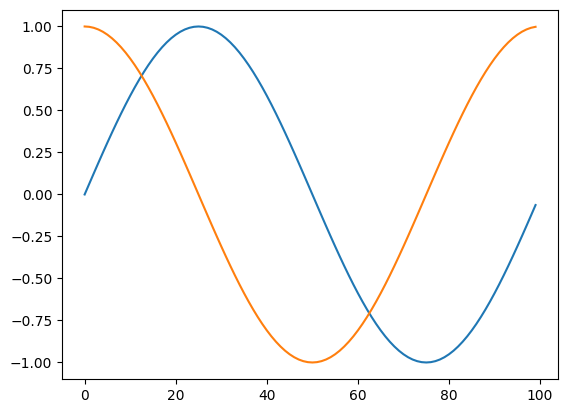

In [ ]:
bs, c_in, seq_len = 1,3,100
t = TSTensor(torch.rand(bs, c_in, seq_len))
enc_t = TSCyclicalPosition()(t)
test_ne(enc_t, t)
assert t.shape[1] == enc_t.shape[1] - 2
plt.plot(enc_t[0, -2:].cpu().numpy().T)
plt.show()

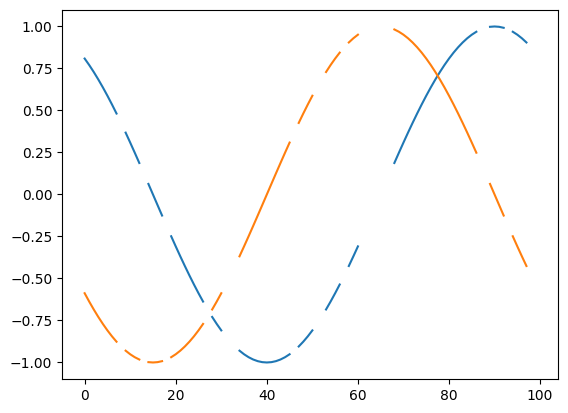

In [ ]:
bs, c_in, seq_len = 1,3,100
t1 = torch.rand(bs, c_in, seq_len)
t2 = torch.arange(seq_len)
t2 = torch.cat([t2[35:], t2[:35]]).reshape(1, 1, -1)
t = TSTensor(torch.cat([t1, t2], 1))
mask = torch.rand_like(t) > .8
t[mask] = np.nan
enc_t = TSCyclicalPosition(3)(t)
test_ne(enc_t, t)
assert t.shape[1] == enc_t.shape[1] - 2
plt.plot(enc_t[0, -2:].cpu().numpy().T)
plt.show()

In [ ]:
#|export
class TSLinearPosition(Transform):
    "Concatenates the position along the sequence as 1 additional variable"

    order = 90
    def __init__(self, 
        linear_var:int=None, # Optional variable to indicate the steps withing the cycle (ie minute of the day)
        var_range:tuple=None, # Optional range indicating min and max values of the linear variable
        magnitude=None, # Added for compatibility. It's not used.
        drop_var:bool=False, # Flag to indicate if the cyclical var is removed
        lin_range:tuple=(-1,1), 
        **kwargs): 
        self.linear_var, self.var_range, self.drop_var, self.lin_range = linear_var, var_range, drop_var, lin_range
        super().__init__(**kwargs)

    def encodes(self, o: TSTensor): 
        bs,nvars,seq_len = o.shape
        if self.linear_var is None:
            lin = linear_encoding(seq_len, device=o.device, lin_range=self.lin_range)
            output = torch.cat([o, lin.reshape(1,1,-1).repeat(bs,1,1)], 1)
        else:
            linear_var = o[:, [self.linear_var]]
            if self.var_range is None:
                lin = (linear_var - linear_var.min()) / (linear_var.max() - linear_var.min())
            else:
                lin = (linear_var - self.var_range[0]) / (self.var_range[1] - self.var_range[0])
            lin = (linear_var - self.lin_range[0]) / (self.lin_range[1] - self.lin_range[0])
            if self.drop_var:
                exc_vars = np.isin(np.arange(nvars), self.linear_var, invert=True)
                output = torch.cat([o[:, exc_vars], lin], 1)
            else:
                output = torch.cat([o, lin], 1)
            return output
        return output

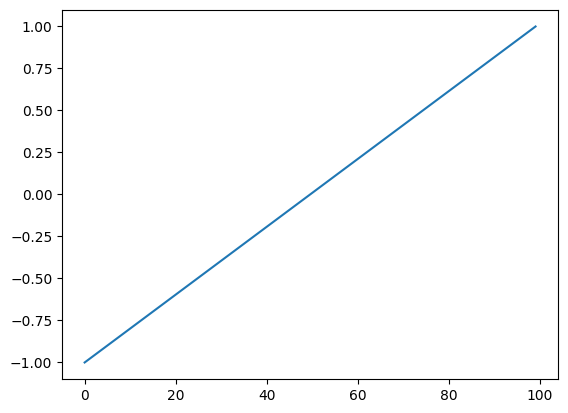

In [ ]:
bs, c_in, seq_len = 1,3,100
t = TSTensor(torch.rand(bs, c_in, seq_len))
enc_t = TSLinearPosition()(t)
test_ne(enc_t, t)
assert t.shape[1] == enc_t.shape[1] - 1
plt.plot(enc_t[0, -1].cpu().numpy().T)
plt.show()

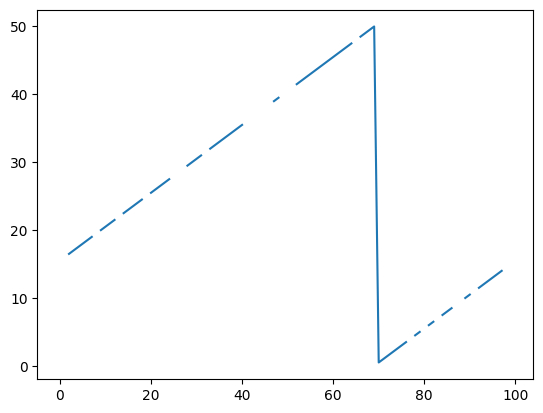

In [ ]:
t = torch.arange(100)
t1 = torch.cat([t[30:], t[:30]]).reshape(1, 1, -1)
t2 = torch.cat([t[52:], t[:52]]).reshape(1, 1, -1)
t = torch.cat([t1, t2]).float()
mask = torch.rand_like(t) > .8
t[mask] = np.nan
t = TSTensor(t)
enc_t = TSLinearPosition(linear_var=0, var_range=(0, 100), drop_var=True)(t)
test_ne(enc_t, t)
assert t.shape[1] == enc_t.shape[1]
plt.plot(enc_t[0, -1].cpu().numpy().T)
plt.show()

In [ ]:
#|export
class TSMissingness(Transform):
    "Concatenates data missingness for selected features along the sequence as additional variables"

    order = 90
    def __init__(self, sel_vars=None, feature_idxs=None, magnitude=None, **kwargs):
        sel_vars = sel_vars or feature_idxs
        self.sel_vars = listify(sel_vars)
        super().__init__(**kwargs)

    def encodes(self, o: TSTensor):
        if self.sel_vars is not None:
            missingness = o[:, self.sel_vars].isnan()
        else:
            missingness = o.isnan()
        return torch.cat([o, missingness], 1)

In [ ]:
bs, c_in, seq_len = 1,3,100
t = TSTensor(torch.rand(bs, c_in, seq_len))
t[t>.5] = np.nan
enc_t = TSMissingness(sel_vars=[0,2])(t)
test_eq(enc_t.shape[1], 5)
test_eq(enc_t[:, 3:], torch.isnan(t[:, [0,2]]).float())

In [ ]:
#|export
class TSPositionGaps(Transform):
    """Concatenates gaps for selected features along the sequence as additional variables"""

    order = 90
    def __init__(self, sel_vars=None, feature_idxs=None, magnitude=None, forward=True, backward=False, 
                 nearest=False, normalize=True, **kwargs):
        sel_vars = sel_vars or feature_idxs
        self.sel_vars = listify(sel_vars)
        self.gap_fn = partial(get_gaps, forward=forward, backward=backward, nearest=nearest, normalize=normalize)
        super().__init__(**kwargs)

    def encodes(self, o: TSTensor):
        if self.sel_vars:
            gaps = self.gap_fn(o[:, self.sel_vars])
        else:
            gaps = self.gap_fn(o)
        return torch.cat([o, gaps], 1)

In [ ]:
bs, c_in, seq_len = 1,3,8
t = TSTensor(torch.rand(bs, c_in, seq_len))
t[t>.5] = np.nan
enc_t = TSPositionGaps(sel_vars=[0,2], forward=True, backward=True, nearest=True, normalize=False)(t)
test_eq(enc_t.shape[1], 9)
enc_t.data

tensor([[[   nan,    nan, 0.1005,    nan,    nan,    nan, 0.1081, 0.3630],
         [0.3359, 0.0689,    nan,    nan, 0.4788,    nan, 0.3174,    nan],
         [   nan,    nan, 0.2658, 0.1227,    nan, 0.1283, 0.4167, 0.3684],
         [1.0000, 2.0000, 3.0000, 1.0000, 2.0000, 3.0000, 4.0000, 1.0000],
         [1.0000, 2.0000, 3.0000, 1.0000, 1.0000, 2.0000, 1.0000, 1.0000],
         [2.0000, 1.0000, 4.0000, 3.0000, 2.0000, 1.0000, 1.0000, 1.0000],
         [2.0000, 1.0000, 1.0000, 2.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 3.0000, 1.0000, 2.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]])

In [ ]:
#|export
class TSRollingMean(Transform):
    """Calculates the rolling mean for all/ selected features alongside the sequence
    
       It replaces the original values or adds additional variables (default)
       If nan values are found, they will be filled forward and backward"""

    order = 90
    def __init__(self, sel_vars=None, feature_idxs=None, magnitude=None, window=2, replace=False, **kwargs):
        sel_vars = sel_vars or feature_idxs
        self.sel_vars = listify(sel_vars)
        self.rolling_mean_fn = partial(rolling_moving_average, window=window)
        self.replace = replace
        super().__init__(**kwargs)

    def encodes(self, o: TSTensor):
        if self.sel_vars:
            if torch.isnan(o[:, self.sel_vars]).any():
                o[:, self.sel_vars] = fbfill_sequence(o[:, self.sel_vars])
            rolling_mean = self.rolling_mean_fn(o[:, self.sel_vars])
            if self.replace: 
                o[:, self.sel_vars] = rolling_mean
                return o
        else:
            if torch.isnan(o).any():
                o = fbfill_sequence(o)
            rolling_mean = self.rolling_mean_fn(o)
            if self.replace: return rolling_mean
        return torch.cat([o, rolling_mean], 1)

In [ ]:
bs, c_in, seq_len = 1,3,8
t = TSTensor(torch.rand(bs, c_in, seq_len))
t[t > .6] = np.nan
print(t.data)
enc_t = TSRollingMean(sel_vars=[0,2], window=3)(t)
test_eq(enc_t.shape[1], 5)
print(enc_t.data)
enc_t = TSRollingMean(window=3, replace=True)(t)
test_eq(enc_t.shape[1], 3)
print(enc_t.data)

tensor([[[0.4947, 0.2501, 0.2929, 0.2400, 0.1093,    nan,    nan, 0.1987],
         [   nan,    nan, 0.5726,    nan,    nan,    nan,    nan, 0.0756],
         [0.4248, 0.0369, 0.4553, 0.3549, 0.1981, 0.4931,    nan, 0.2255]]])
tensor([[[0.4947, 0.2501, 0.2929, 0.2400, 0.1093, 0.1093, 0.1093, 0.1987],
         [   nan,    nan, 0.5726,    nan,    nan,    nan,    nan, 0.0756],
         [0.4248, 0.0369, 0.4553, 0.3549, 0.1981, 0.4931, 0.4931, 0.2255],
         [0.4947, 0.3724, 0.3459, 0.2610, 0.2141, 0.1529, 0.1093, 0.1391],
         [0.4248, 0.2308, 0.3056, 0.2823, 0.3361, 0.3487, 0.3948, 0.4039]]])
tensor([[[0.4947, 0.3724, 0.3459, 0.2610, 0.2141, 0.1529, 0.1093, 0.1391],
         [0.5726, 0.5726, 0.5726, 0.5726, 0.5726, 0.5726, 0.5726, 0.4069],
         [0.4248, 0.2308, 0.3056, 0.2823, 0.3361, 0.3487, 0.3948, 0.4039]]])


In [ ]:
#|export
class TSLogReturn(Transform):
    "Calculates log-return of batch of type `TSTensor`. For positive values only"
    order = 90
    def __init__(self, lag=1, pad=True, **kwargs):
        super().__init__(**kwargs)
        self.lag, self.pad = lag, pad

    def encodes(self, o:TSTensor):
        return torch_diff(torch.log(o), lag=self.lag, pad=self.pad)

    def __repr__(self): return f'{self.__class__.__name__}(lag={self.lag}, pad={self.pad})'

In [ ]:
t = TSTensor([1,2,4,8,16,32,64,128,256]).float()
test_eq(TSLogReturn(pad=False)(t).std(), 0)

In [ ]:
#|export
class TSAdd(Transform):
    "Add a defined amount to each batch of type `TSTensor`."
    order = 90
    def __init__(self, add, **kwargs):
        super().__init__(**kwargs)
        self.add = add

    def encodes(self, o:TSTensor):
        return torch.add(o, self.add)
    def __repr__(self): return f'{self.__class__.__name__}(lag={self.lag}, pad={self.pad})'

In [ ]:
t = TSTensor([1,2,3]).float()
test_eq(TSAdd(1)(t), TSTensor([2,3,4]).float())

In [ ]:
#|export
class TSClipByVar(Transform):
    """Clip  batch of type `TSTensor` by variable
    
    Args:
        var_min_max: list of tuples containing variable index, min value (or None) and max value (or None)
    """
    order = 90
    def __init__(self, var_min_max, **kwargs):
        super().__init__(**kwargs)
        self.var_min_max = var_min_max

    def encodes(self, o:TSTensor):
        for v,m,M in self.var_min_max:
            o[:, v] = torch.clamp(o[:, v], m, M)
        return o

In [ ]:
t = TSTensor(torch.rand(16, 3, 10) * tensor([1,10,100]).reshape(1,-1,1))
max_values = t.max(0).values.max(-1).values.data
max_values2 = TSClipByVar([(1,None,5), (2,10,50)])(t).max(0).values.max(-1).values.data
test_le(max_values2[1], 5)
test_ge(max_values2[2], 10)
test_le(max_values2[2], 50)

In [ ]:
#|export
class TSDropVars(Transform):
    "Drops selected variable from the input"
    order = 90
    def __init__(self, drop_vars, **kwargs):
        super().__init__(**kwargs)
        self.drop_vars = drop_vars

    def encodes(self, o:TSTensor):
        exc_vars = np.isin(np.arange(o.shape[1]), self.drop_vars, invert=True)
        return o[:, exc_vars]

In [ ]:
t = TSTensor(torch.arange(24).reshape(2, 3, 4))
enc_t = TSDropVars(2)(t)
test_ne(t, enc_t)
enc_t.data

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19]]])

In [ ]:
#|export
class TSOneHotEncode(Transform):
    order = 90
    def __init__(self,
        sel_var:int, # Variable that is one-hot encoded
        unique_labels:list, # List containing all labels (excluding nan values)
        add_na:bool=False, # Flag to indicate if values not included in vocab should be set as 0
        drop_var:bool=True, # Flag to indicate if the selected var is removed
        magnitude=None, # Added for compatibility. It's not used.
        **kwargs
        ):
        unique_labels = listify(unique_labels)
        self.sel_var = sel_var
        self.unique_labels = unique_labels
        self.n_classes = len(unique_labels) + add_na
        self.add_na = add_na
        self.drop_var = drop_var
        super().__init__(**kwargs)
        
    def encodes(self, o: TSTensor):
        bs, n_vars, seq_len = o.shape
        o_var = o[:, [self.sel_var]]
        ohe_var = torch.zeros(bs, self.n_classes, seq_len, device=o.device)
        if self.add_na:
            is_na = torch.isin(o_var, o_var.new(list(self.unique_labels)), invert=True) # not available in dict
            ohe_var[:, [0]] = is_na.to(ohe_var.dtype)
        for i,l in enumerate(self.unique_labels):
            ohe_var[:, [i + self.add_na]] = (o_var == l).to(ohe_var.dtype)
        if self.drop_var:
            exc_vars = torch.isin(torch.arange(o.shape[1], device=o.device), self.sel_var, invert=True)
            output = torch.cat([o[:, exc_vars], ohe_var], 1)
        else:
            output = torch.cat([o, ohe_var], 1)
        return output

In [ ]:
bs = 2
seq_len = 5
t_cont = torch.rand(bs, 1, seq_len)
t_cat = torch.randint(0, 3, t_cont.shape)
t = TSTensor(torch.cat([t_cat, t_cont], 1))
t_cat

tensor([[[1, 0, 2, 1, 1]],

        [[2, 1, 0, 1, 1]]])

In [ ]:
tfm = TSOneHotEncode(0, [0, 1, 2])
output = tfm(t)[:, -3:].data
test_eq(t_cat, torch.argmax(tfm(t)[:, -3:], 1)[:, None])
tfm(t)[:, -3:].data

tensor([[[0., 1., 0., 0., 0.],
         [1., 0., 0., 1., 1.],
         [0., 0., 1., 0., 0.]],

        [[0., 0., 1., 0., 0.],
         [0., 1., 0., 1., 1.],
         [1., 0., 0., 0., 0.]]])

In [ ]:
bs = 2
seq_len = 5
t_cont = torch.rand(bs, 1, seq_len)
t_cat = torch.tensor([[10.,  5., 11., np.nan, 12.], [ 5., 12., 10., np.nan, 11.]])[:, None]
t = TSTensor(torch.cat([t_cat, t_cont], 1))
t_cat

tensor([[[10.,  5., 11., nan, 12.]],

        [[ 5., 12., 10., nan, 11.]]])

In [ ]:
tfm = TSOneHotEncode(0, [10, 11, 12], drop_var=False)
mask = ~torch.isnan(t[:, 0])
test_eq(tfm(t)[:, 0][mask], t[:, 0][mask])
tfm(t)[:, -3:].data

tensor([[[1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1.]],

        [[0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0.]]])

In [ ]:
t1 = torch.randint(3, 7, (2, 1, 10))
t2 = torch.rand(2, 1, 10)
t = TSTensor(torch.cat([t1, t2], 1))
output = TSOneHotEncode(0, [3, 4, 5], add_na=True, drop_var=True)(t)
test_eq((t1 > 5).float(), output.data[:, [1]])
test_eq((t1 == 3).float(), output.data[:, [2]])
test_eq((t1 == 4).float(), output.data[:, [3]])
test_eq((t1 == 5).float(), output.data[:, [4]])
test_eq(output.shape, (t.shape[0], 5, t.shape[-1]))

In [ ]:
#|export
class TSPosition(Transform):
    order = 90
    def __init__(self,
        steps:list, # List containing the steps passed as an additional variable. Theu should be normalized.
        magnitude=None, # Added for compatibility. It's not used.
        **kwargs
        ):
        self.steps = torch.from_numpy(np.asarray(steps)).reshape(1, 1, -1)
        super().__init__(**kwargs)

    def encodes(self, o: TSTensor):
        bs = o.shape[0]
        steps = self.steps.expand(bs, -1, -1).to(device=o.device, dtype=o.dtype)
        return torch.cat([o, steps], 1)

In [ ]:
t = TSTensor(torch.rand(2, 1, 10)).float()
a = np.linspace(-1, 1, 10).astype('float64')
TSPosition(a)(t).data.dtype, t.dtype

(torch.float32, torch.float32)

# sklearn API transforms

In [ ]:
#|export
from sklearn.base import BaseEstimator, TransformerMixin
from fastai.data.transforms import CategoryMap
from joblib import dump, load


class TSShrinkDataFrame(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None, skip=[], obj2cat=True, int2uint=False, verbose=True):
        self.columns, self.skip, self.obj2cat, self.int2uint, self.verbose = listify(columns), skip, obj2cat, int2uint, verbose
        
    def fit(self, X:pd.DataFrame, y=None, **fit_params):
        assert isinstance(X, pd.DataFrame)
        self.old_dtypes = X.dtypes            
        if not self.columns: self.columns = X.columns
        self.dt = df_shrink_dtypes(X[self.columns], self.skip, obj2cat=self.obj2cat, int2uint=self.int2uint)
        return self
        
    def transform(self, X:pd.DataFrame, y=None, **transform_params):
        assert isinstance(X, pd.DataFrame)
        if self.verbose:
            start_memory = X.memory_usage().sum() / 1024**2
            print(f"Memory usage of dataframe is {start_memory} MB")
        X[self.columns] = X[self.columns].astype(self.dt)
        if self.verbose:
            end_memory = X.memory_usage().sum() / 1024**2
            print(f"Memory usage of dataframe after reduction {end_memory} MB")
            print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
        return X
         
    def inverse_transform(self, X):
        assert isinstance(X, pd.DataFrame)
        if self.verbose:
            start_memory = X.memory_usage().sum() / 1024**2
            print(f"Memory usage of dataframe is {start_memory} MB")
        X = X.astype(self.old_dtypes)
        if self.verbose:
            end_memory = X.memory_usage().sum() / 1024**2
            print(f"Memory usage of dataframe after reduction {end_memory} MB")
            print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
        return X

In [ ]:
df = pd.DataFrame()
df["ints64"] = np.random.randint(0,3,10)
df['floats64'] = np.random.rand(10)
tfm = TSShrinkDataFrame()
tfm.fit(df)
df = tfm.transform(df)
test_eq(df["ints64"].dtype, "int8")
test_eq(df["floats64"].dtype, "float32")

Memory usage of dataframe is 0.000274658203125 MB
Memory usage of dataframe after reduction 0.0001697540283203125 MB
Reduced by 38.19444444444444 % 


In [ ]:
#|export
class TSOneHotEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None, drop=True, add_na=True, dtype=np.int64):
        self.columns = listify(columns)
        self.drop, self.add_na, self.dtype = drop, add_na, dtype
        

    def fit(self, X:pd.DataFrame, y=None, **fit_params):
        assert isinstance(X, pd.DataFrame)
        if not self.columns: self.columns = X.columns
        handle_unknown = "ignore" if self.add_na else "error"
        self.ohe_tfm = sklearn.preprocessing.OneHotEncoder(handle_unknown=handle_unknown)
        if len(self.columns) == 1:
            self.ohe_tfm.fit(X[self.columns].to_numpy().reshape(-1, 1))
        else: 
            self.ohe_tfm.fit(X[self.columns])
        return self

    def transform(self, X:pd.DataFrame, y=None, **transform_params):
        assert isinstance(X, pd.DataFrame)
        if len(self.columns) == 1:
            output = self.ohe_tfm.transform(X[self.columns].to_numpy().reshape(-1, 1)).toarray().astype(self.dtype)
        else: 
            output = self.ohe_tfm.transform(X[self.columns]).toarray().astype(self.dtype)
        new_cols = []
        for i,col in enumerate(self.columns): 
            for cats in self.ohe_tfm.categories_[i]:
                new_cols.append(f"{str(col)}_{str(cats)}")
        X[new_cols] = output
        if self.drop: X = X.drop(self.columns, axis=1)
        return X

In [ ]:
df = pd.DataFrame()
df["a"] = np.random.randint(0,2,10)
df["b"] = np.random.randint(0,3,10)
unique_cols = len(df["a"].unique()) + len(df["b"].unique())
tfm = TSOneHotEncoder()
tfm.fit(df)
df = tfm.transform(df)
test_eq(df.shape[1], unique_cols)

In [ ]:
#|export
class TSCategoricalEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None, add_na=True, prefix=None, suffix=None, verbose=True):
        self.columns = listify(columns)
        self.add_na = add_na
        self.prefix = prefix
        self.suffix = suffix
        self.verbose = verbose

    def fit(self, X:pd.DataFrame, y=None, **fit_params):
        assert isinstance(X, pd.DataFrame)
        if not self.columns: self.columns = X.columns
        self.cat_tfms = []
        for column in self.columns:
            self.cat_tfms.append(CategoryMap(X[column], add_na=self.add_na))
        return self

    def transform(self, X:pd.DataFrame, y=None, **transform_params):
        assert isinstance(X, pd.DataFrame)
        for cat_tfm, column in zip(self.cat_tfms, self.columns):
            new_col = column
            if self.prefix is not None:
                new_col = self.prefix + str(new_col)
            if self.suffix is not None: 
                new_col = str(new_col) + self.suffix
            pv(f'encoding {column}...', self.verbose)
            X[new_col] = cat_tfm.map_objs(X[column])
            pv(f'...{column} encoded', self.verbose)
        return X

    def inverse_transform(self, X:pd.DataFrame):
        assert isinstance(X, pd.DataFrame)
        for cat_tfm, column in zip(self.cat_tfms, self.columns):
            new_col = column
            if self.prefix is not None:
                new_col = self.prefix + str(new_col)
            if self.suffix is not None: 
                new_col = str(new_col) + self.suffix
            pv(f'decoding {new_col}...', self.verbose)
            X[new_col] = cat_tfm.map_ids(X[new_col])
            pv(f'...{new_col} decoded', self.verbose)
        return X

Stateful transforms like TSCategoricalEncoder can easily be serialized. 

In [ ]:
import joblib

In [ ]:
df = pd.DataFrame()
df["a"] = alphabet[np.random.randint(0,2,100)]
df["b"] = ALPHABET[np.random.randint(0,3,100)]
a_unique = len(df["a"].unique())
b_unique = len(df["b"].unique())
tfm = TSCategoricalEncoder()
tfm.fit(df)
joblib.dump(tfm, "data/TSCategoricalEncoder.joblib")
tfm = joblib.load("data/TSCategoricalEncoder.joblib")
df = tfm.transform(df)
test_eq(df['a'].max(), a_unique)
test_eq(df['b'].max(), b_unique)

encoding a...
...a encoded
encoding b...
...b encoded


In [ ]:
#|export
default_date_attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
                     'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

class TSDateTimeEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, datetime_columns=None, prefix=None, drop=True, time=False, attr=default_date_attr):
        self.datetime_columns = listify(datetime_columns)
        self.prefix, self.drop, self.time, self.attr = prefix, drop, time ,attr
        
    def fit(self, X:pd.DataFrame, y=None, **fit_params):
        assert isinstance(X, pd.DataFrame)
        if self.time: self.attr = self.attr + ['Hour', 'Minute', 'Second']
        if not self.datetime_columns:
            self.datetime_columns = X.columns
        self.prefixes = []
        for dt_column in self.datetime_columns: 
            self.prefixes.append(re.sub('[Dd]ate$', '', dt_column) if self.prefix is None else self.prefix)
        return self
        
    def transform(self, X:pd.DataFrame, y=None, **transform_params):
        assert isinstance(X, pd.DataFrame)
        
        for dt_column,prefix in zip(self.datetime_columns,self.prefixes): 
            make_date(X, dt_column)
            field = X[dt_column]

            # Pandas removed `dt.week` in v1.1.10
            week = field.dt.isocalendar().week.astype(field.dt.day.dtype) if hasattr(field.dt, 'isocalendar') else field.dt.week
            for n in self.attr: X[prefix + "_" + n] = getattr(field.dt, n.lower()) if n != 'Week' else week
            if self.drop: X = X.drop(self.datetime_columns, axis=1)
        return X

In [ ]:
import datetime

In [ ]:
df = pd.DataFrame()
df.loc[0, "date"] = datetime.datetime.now()
df.loc[1, "date"] = datetime.datetime.now() + pd.Timedelta(1, unit="D")
tfm = TSDateTimeEncoder()
joblib.dump(tfm, "data/TSDateTimeEncoder.joblib")
tfm = joblib.load("data/TSDateTimeEncoder.joblib")
tfm.fit_transform(df)

,_Year,_Month,_Week,_Day,_Dayofweek,_Dayofyear,_Is_month_end,_Is_month_start,_Is_quarter_end,_Is_quarter_start,_Is_year_end,_Is_year_start
0,2023,2,6,8,2,39,False,False,False,False,False,False
1,2023,2,6,9,3,40,False,False,False,False,False,False


In [ ]:
#|export
class TSMissingnessEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None):
        self.columns = listify(columns)
        
    def fit(self, X:pd.DataFrame, y=None, **fit_params):
        assert isinstance(X, pd.DataFrame)
        if not self.columns: self.columns = X.columns
        self.missing_columns = [f"{cn}_missing" for cn in self.columns]
        return self
        
    def transform(self, X:pd.DataFrame, y=None, **transform_params):
        assert isinstance(X, pd.DataFrame)
        X[self.missing_columns] = X[self.columns].isnull().astype(int)
        return X
         
    def inverse_transform(self, X):
        assert isinstance(X, pd.DataFrame)
        X.drop(self.missing_columns, axis=1, inplace=True)
        return X

In [ ]:
data = np.random.rand(10,3)
data[data > .8] = np.nan
df = pd.DataFrame(data, columns=["a", "b", "c"])
tfm = TSMissingnessEncoder()
tfm.fit(df)
joblib.dump(tfm, "data/TSMissingnessEncoder.joblib")
tfm = joblib.load("data/TSMissingnessEncoder.joblib")
df = tfm.transform(df)
df

,a,b,c,a_missing,b_missing,c_missing
0,0.790656,0.712222,0.147748,0,0,0
1,0.321025,0.505795,0.702930,0,0,0
2,0.015043,0.478355,0.404446,0,0,0
3,0.144443,0.016810,0.315640,0,0,0
4,NaN,0.370467,0.525869,1,0,0
5,0.739812,0.377864,0.395936,0,0,0
6,0.347011,0.158904,0.002939,0,0,0
7,0.572850,NaN,0.213721,0,1,0
8,0.164747,0.441939,0.741301,0,0,0
9,0.182679,0.525158,0.509122,0,0,0


## y transforms

In [ ]:
#|export
class Preprocessor():
    def __init__(self, preprocessor, **kwargs): 
        self.preprocessor = preprocessor(**kwargs)
        
    def fit(self, o): 
        if isinstance(o, pd.Series): o = o.values.reshape(-1,1)
        else: o = o.reshape(-1,1)
        self.fit_preprocessor = self.preprocessor.fit(o)
        return self.fit_preprocessor
    
    def transform(self, o, copy=True):
        if type(o) in [float, int]: o = array([o]).reshape(-1,1)
        o_shape = o.shape
        if isinstance(o, pd.Series): o = o.values.reshape(-1,1)
        else: o = o.reshape(-1,1)
        output = self.fit_preprocessor.transform(o).reshape(*o_shape)
        if isinstance(o, torch.Tensor): return o.new(output)
        return output
    
    def inverse_transform(self, o, copy=True):
        o_shape = o.shape
        if isinstance(o, pd.Series): o = o.values.reshape(-1,1)
        else: o = o.reshape(-1,1)
        output = self.fit_preprocessor.inverse_transform(o).reshape(*o_shape)
        if isinstance(o, torch.Tensor): return o.new(output)
        return output


StandardScaler = partial(sklearn.preprocessing.StandardScaler)
setattr(StandardScaler, '__name__', 'StandardScaler')
RobustScaler = partial(sklearn.preprocessing.RobustScaler)
setattr(RobustScaler, '__name__', 'RobustScaler')
Normalizer = partial(sklearn.preprocessing.MinMaxScaler, feature_range=(-1, 1))
setattr(Normalizer, '__name__', 'Normalizer')
BoxCox = partial(sklearn.preprocessing.PowerTransformer, method='box-cox')
setattr(BoxCox, '__name__', 'BoxCox')
YeoJohnshon = partial(sklearn.preprocessing.PowerTransformer, method='yeo-johnson')
setattr(YeoJohnshon, '__name__', 'YeoJohnshon')
Quantile = partial(sklearn.preprocessing.QuantileTransformer, n_quantiles=1_000, output_distribution='normal', random_state=0)
setattr(Quantile, '__name__', 'Quantile')

In [ ]:
# Standardize
from tsai.data.validation import TimeSplitter

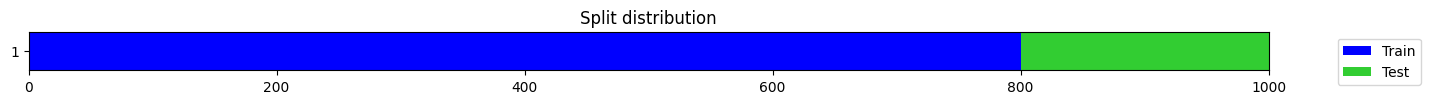

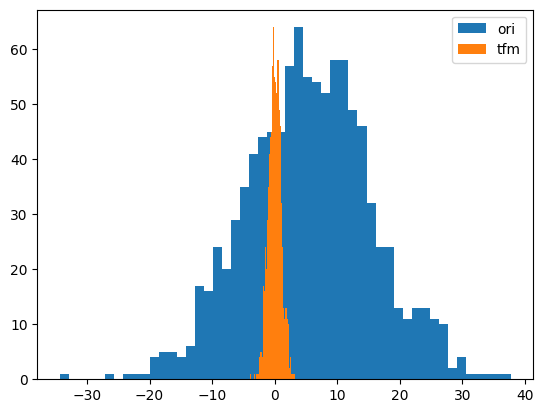

In [ ]:
y = random_shuffle(np.random.randn(1000) * 10 + 5)
splits = TimeSplitter()(y)
preprocessor = Preprocessor(StandardScaler)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

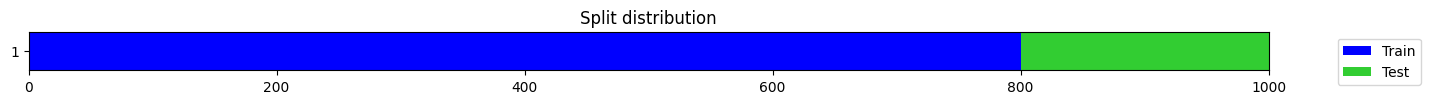

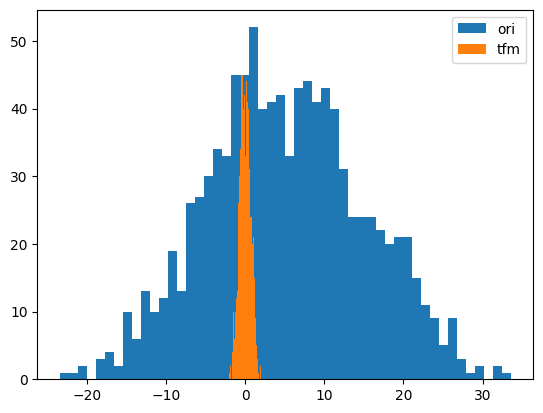

In [ ]:
# RobustScaler
y = random_shuffle(np.random.randn(1000) * 10 + 5)
splits = TimeSplitter()(y)
preprocessor = Preprocessor(RobustScaler)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

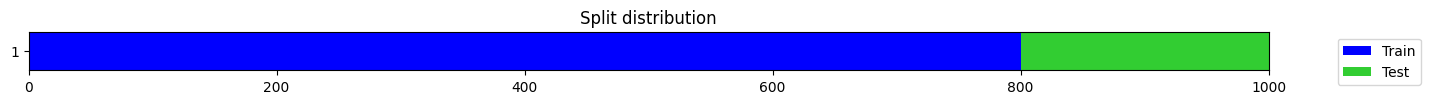

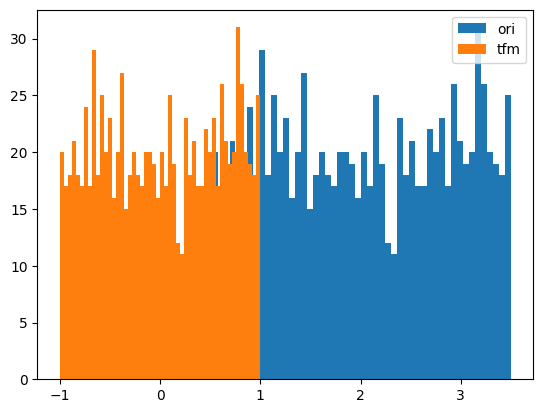

In [ ]:
# Normalize
y = random_shuffle(np.random.rand(1000) * 3 + .5)
splits = TimeSplitter()(y)
preprocessor = Preprocessor(Normalizer)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

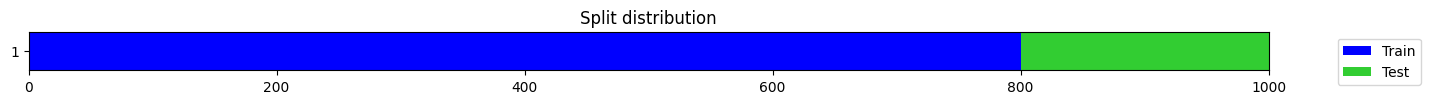

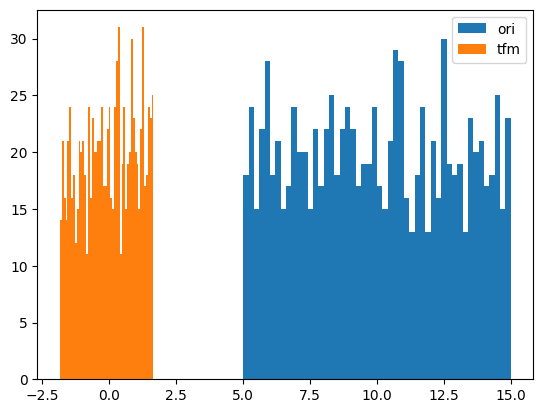

In [ ]:
# BoxCox
y = random_shuffle(np.random.rand(1000) * 10 + 5)
splits = TimeSplitter()(y)
preprocessor = Preprocessor(BoxCox)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

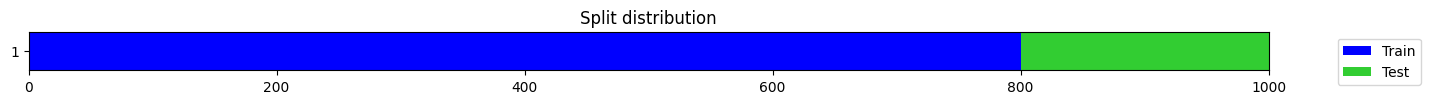

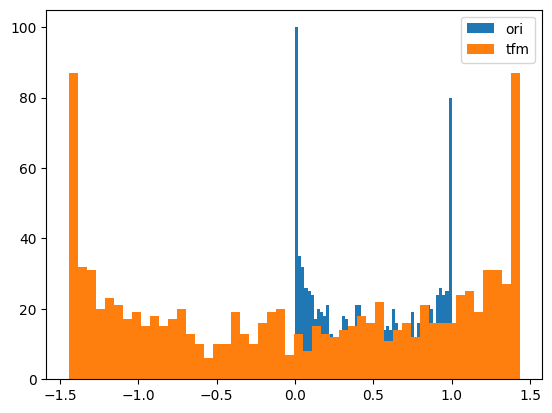

In [ ]:
# YeoJohnshon
y = random_shuffle(np.random.randn(1000) * 10 + 5)
y = np.random.beta(.5, .5, size=1000)
splits = TimeSplitter()(y)
preprocessor = Preprocessor(YeoJohnshon)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

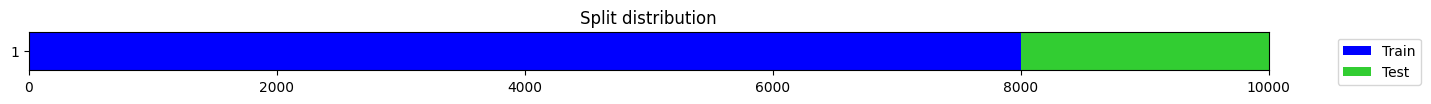

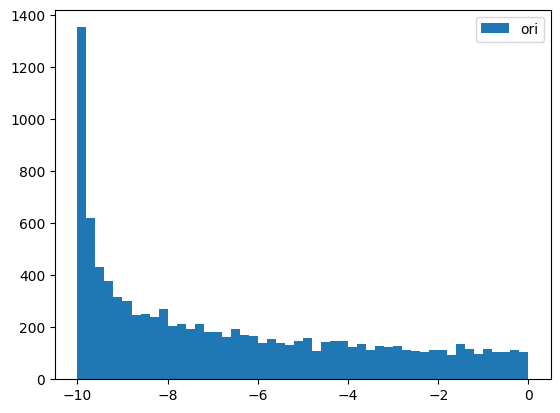

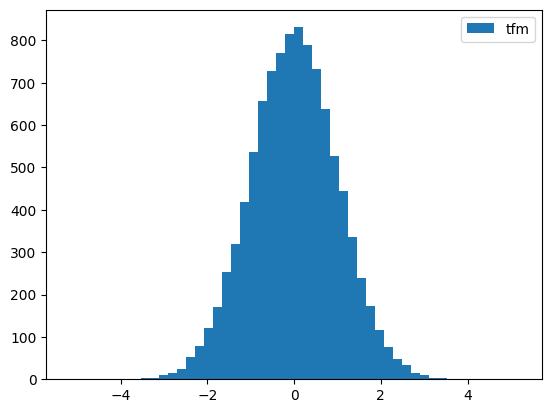

In [ ]:
# QuantileTransformer
y = - np.random.beta(1, .5, 10000) * 10
splits = TimeSplitter()(y)
preprocessor = Preprocessor(Quantile)
preprocessor.fit(y[splits[0]])
plt.hist(y, 50, label='ori',)
y_tfm = preprocessor.transform(y)
plt.legend(loc='best')
plt.show()
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()
test_close(preprocessor.inverse_transform(y_tfm), y, 1e-1)

In [ ]:
#|export
def ReLabeler(cm):
    r"""Changes the labels in a dataset based on a dictionary (class mapping) 
        Args:
            cm = class mapping dictionary
    """
    def _relabel(y):
        obj = len(set([len(listify(v)) for v in cm.values()])) > 1
        keys = cm.keys()
        if obj: 
            new_cm = {k:v for k,v in zip(keys, [listify(v) for v in cm.values()])}
            return np.array([new_cm[yi] if yi in keys else listify(yi) for yi in y], dtype=object).reshape(*y.shape)
        else: 
            new_cm = {k:v for k,v in zip(keys, [listify(v) for v in cm.values()])}
            return np.array([new_cm[yi] if yi in keys else listify(yi) for yi in y]).reshape(*y.shape)
    return _relabel

In [ ]:
vals = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e'}
y = np.array([vals[i] for i in np.random.randint(0, 5, 20)])
labeler = ReLabeler(dict(a='x', b='x', c='y', d='z', e='z'))
y_new = labeler(y)
test_eq(y.shape, y_new.shape)
y, y_new

(array(['b', 'd', 'a', 'e', 'd', 'c', 'a', 'd', 'b', 'c', 'd', 'b', 'e',
        'd', 'a', 'a', 'b', 'd', 'b', 'b'], dtype='<U1'),
 array(['x', 'z', 'x', 'z', 'z', 'y', 'x', 'z', 'x', 'y', 'z', 'x', 'z',
        'z', 'x', 'x', 'x', 'z', 'x', 'x'], dtype='<U1'))

In [ ]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

<IPython.core.display.Javascript object>

/Users/nacho/notebooks/tsai/nbs/009_data.preprocessing.ipynb saved at 2023-02-08 18:34:02
Correct notebook to script conversion! 😃
Wednesday 08/02/23 18:34:06 CET
